# 示例：使用 U-net 进行图像分割

我们选择 Kaggle 数据集 <https://www.kaggle.com/datasets/ipythonx/carvana-image-masking-png/code?datasetId=1843391&searchQuery=pytorch>

将数据压缩文件下载到 `../data/carvana`并解压，完成后数据目录为：

```
data/carvana/
        |-  train_images/
        |       |-  **_*.jpg
        |
        |-  train_masks/
                |-  **_*.png
```

同一张图片对应的 `.jpg` 图片和 `.png` 分割图同名。

In [1]:
import torch 
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

## 1. 数据集

按照 0.9 的概率分割数据集，并使用 `SizedData` 类管理成对的 GT 数据。或直接使用 `data/carvana_split` 目录中的分割方式。

In [4]:
# 若需要重新分割数据集，去除本单元格最后一行的注释，并修改随机种子。
from pathlib import Path 
import random

def split_dataset(root: str, prob: float, seed: int):
    train = []
    test = []
    root_dir = Path(root)

    random.seed(seed)
    for file in (root_dir / "carvana" / "train_images/").glob('*'):
        split = train if random.random() < prob else test 
        split.append(file.stem)

    split_dir = root_dir / "carvana_split"
    split_dir.mkdir(parents=True, exist_ok=True)

    # 写入 train.txt
    with open(split_dir / "train.txt", "w") as f:
        for file_name in train:
            f.write(file_name + "\n")

    # 写入 test.txt
    with open(split_dir / "test.txt", "w") as f:
        for file_name in test:
            f.write(file_name + "\n")

# split_dataset(root="../data/", prob=0.9, seed=0)

In [2]:
import numpy as np
from src.modules import SizedDataset
from pathlib import Path
from PIL import Image
from torchvision import transforms


class CarvanaDataset(SizedDataset):
    def __init__(self, root: str, train: bool = True, size: int = 256) -> None:
        super().__init__()
        self.root_dir = Path(root)
        split_file = "train.txt" if train else "test.txt"
        self.data_list = self.__read_data(self.split_dir / split_file)
        self.size = size
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index: int):
        name = self.data_list[index]
        image_file = self.image_dir / f"{name}.jpg"
        mask_file = self.mask_dir / f"{name}.png"
        
        image = Image.open(image_file)
        mask = Image.open(mask_file)
        
        image_tensor = self.image_transforms(image)
        mask_tensor = self.mask_transforms(mask)
        
        image.close()
        mask.close()
        return image_tensor, mask_tensor
    
    @property
    def image_dir(self):
        return self.root_dir / "carvana" / "train_images"
    
    @property
    def mask_dir(self):
        return self.root_dir / "carvana" / "train_masks"
    
    @property 
    def split_dir(self):
        return self.root_dir / "carvana_split"
    
    def __read_data(self, split_file: Path):
        data_list = []
        with open(split_file) as f:
            for line in f.readlines():
                data_list.append(line.strip())
        return data_list
    
    def image_transforms(self, img) -> torch.Tensor:
        transform = transforms.Compose([
            transforms.Resize([self.size, self.size]),
            transforms.ToTensor()
        ])
        return transform(img)
    
    def mask_transforms(self, mask) -> torch.Tensor:
        resize = transforms.Resize([self.size, self.size])
        mask_array = np.array(resize(mask))
        return torch.from_numpy(mask_array).long()

## 2. 神经网络模型

使用 U-net 作为分割网络

In [4]:
from torch import nn 
from src.modules import NeuralNetwork 

class double_conv_bn(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv_bn_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_bn_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, input_):
        x = self.conv_bn_1(input_)
        out = self.conv_bn_2(x)
        return out

class UnetEncoderLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.double_conv = double_conv_bn(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2, 2)
    
    def forward(self, input_):
        out1 = self.double_conv(input_)
        out2 = self.down_sample(out1)
        return out1, out2

class UnetEncoder(nn.Module):
    def __init__(self, channels_list: list[int], in_channels: int) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        
        for channels in channels_list:
            self.layers.append(
                UnetEncoderLayer(in_channels, channels)
            )
            in_channels = channels
    
    def forward(self, input_):
        outs = []
        x = input_
        for layer in self.layers:
            out1, out2 = layer(x)
            outs.append(out1)
            x = out2 
        return outs, x

class UnetDecoderLayer(nn.Module):
    def __init__(self, in_channels: int, skip_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )
        self.double_conv = double_conv_bn(skip_channels + out_channels, out_channels)
    
    def forward(self, skip, input_):
        out = self.up_conv(input_)
        out = torch.cat([skip, out], dim=1)
        out = self.double_conv(out)
        return out

class UnetDecoder(nn.Module):
    def __init__(self, channels_list: list[int], skip_channels_list: list[int], in_channels: int) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        
        for channels, skip_channels in zip(channels_list, skip_channels_list):
            self.layers.append(
                UnetDecoderLayer(in_channels, skip_channels, channels)
            )
            in_channels = channels
    
    def forward(self, skip_features, input_):
        out = input_
        for layer, skip_feat in zip(self.layers, skip_features):
            out = layer(skip_feat, out)
        return out

class Unet(NeuralNetwork):
    def __init__(self, channels_list: list[int], in_channels: int, out_channels: int) -> None:
        super().__init__()
        enc_channels_list = channels_list[:-1]
        bottleneck_channels = channels_list[-1]
        
        self.encoder = UnetEncoder(enc_channels_list, in_channels)
        self.bottleneck = double_conv_bn(enc_channels_list[-1], bottleneck_channels)
        self.decoder = UnetDecoder(enc_channels_list[::-1], enc_channels_list[::-1], bottleneck_channels)
        self.out = nn.Conv2d(channels_list[0], out_channels, 3, padding=1)
    
    def forward(self, input_):
        skip_features, out = self.encoder(input_)
        out = self.bottleneck(out)
        out = self.decoder(skip_features[::-1], out)
        logit = self.out(out)
        return logit 

## 3. 训练算法模型

使用像素级的交叉熵分类损失作为损失函数。

In [10]:
from src.modules import TrainModel, EvaluateModel
from src.utils import move_batch
from torch import nn
from torch.utils.data import DataLoader


class TrainUnetSegment(TrainModel):
    loss_fn = nn.CrossEntropyLoss()
    _loss_weights = {"cross-entropy": 1.}
    
    def compute_loss(self, network, batch):
        images, masks = batch 
        logits = network(images)
        return {
            "cross-entropy": self.loss_fn(logits, masks)
        }


class EvaluateCarvana(EvaluateModel):
    def __init__(self, root, batch_size, device) -> None:
        self._metrics = ["iou"]
        self.dataset = CarvanaDataset(root, train=False)
        self.batch_size = batch_size
        self.device = torch.device(device)
    
    @torch.no_grad()
    def predict(self, network, batched_image):
        network.eval()
        logits = network(batched_image)
        pred = torch.argmax(logits, dim=1)
        return pred
    
    @torch.no_grad()
    def evaluate(self, network):
        network.to(self.device)
        network.eval()
        iou_sum = 0
        total = 0
        for batch in DataLoader(self.dataset, self.batch_size, num_workers=4):
            batch = move_batch(batch, self.device)
            images, masks = batch 
            preds = self.predict(network, images)
            
            iou_sum += self.compute_batch_iou(preds, masks).sum().item()
            total += images.shape[0]
        return {"iou": iou_sum / total}
    
    def compute_batch_iou(self, pred, ground_truth):
        intersection = (pred * ground_truth).sum(dim=[1,2])
        union = (pred + ground_truth > 0).sum(dim=[1,2])
        return intersection / union

## 4. 训练器

In [11]:
from src.modules import Trainer 
from torch.optim import Adam
from src.plugins import (
    InitializeNetworkPlugin,
    SaveCheckpointPlugin,
    EvaluatePlugin,
    LossLoggerPlugin, MetricLoggerPlugin,
    ProgressBarPlugin,
)

EXP_INDEX = 1


dataset = CarvanaDataset("../data/")
network = Unet([64, 128, 256, 512, 1024], 3, 2)
optimizer = Adam(network.parameters(), lr=0.01)
train_model = TrainUnetSegment()
eval_model = EvaluateCarvana("../data/", 8, device=3)


trainer = (
    Trainer(
        train_model,
        num_epochs=20,
        batch_size=128,
        gradient_accumulation_step = 2,
        init_seed=0,
        device=3
    )
    .add_plugin(InitializeNetworkPlugin())
    .add_plugin(SaveCheckpointPlugin(saving_dir=f"../OUTPUTs/carvana/checkpoint/exp-{EXP_INDEX}", saving_period=4))
    .add_plugin(EvaluatePlugin(eval_model, eval_period=4))
    .add_plugin(LossLoggerPlugin(log_dir=f"../OUTPUTs/carvana/log/exp-{EXP_INDEX}", log_period=3))
    .add_plugin(MetricLoggerPlugin(log_dir=f"../OUTPUTs/carvana/log/exp-{EXP_INDEX}", log_period=4))
    .add_plugin(ProgressBarPlugin())
)

## 5. 训练模型

In [12]:
trainer.loop(dataset, network, optimizer)

## 6. 查看训练结果（TensorBoard）

在 CLI 启动 tensorboard
```bash
cd ~/pytorch-training-framework
tensorboard --logdir OUTPUTs/carvana/log
```

## 7. 使用模型进行推理

随机读取一张图片并使用训练后的模型进行分割。

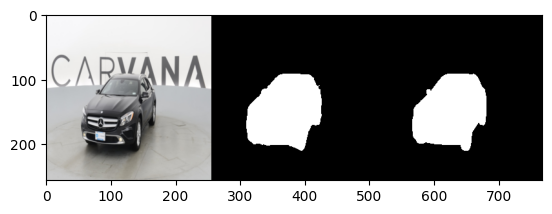

In [46]:
import random 
import matplotlib.pyplot as plt 

# random.seed(0)
index = random.randint(0, len(eval_model.dataset)-1)

img, msk = eval_model.dataset[index]

img.unsqueeze_(0)

pred = eval_model.predict(network, img)
pred.squeeze_(0)

img = (img * 255).long().squeeze(0)


COLMAP = torch.tensor([[0,0,0], [255,255,255]])

plt.imshow(torch.cat([img.permute(1,2,0), COLMAP[pred], COLMAP[msk]], dim=1))
plt.show()